In [1]:
%matplotlib inline
import numpy as np # import numpy library as np
import matplotlib.pyplot as plt # import pyplot library as plt
from mpl_toolkits.mplot3d import Axes3D # import Axes3D from `mpl_toolkits.mplot3d`
import matplotlib.animation as animation
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
plt.style.use('ggplot') # use "ggplot" style for graphs

In [2]:
def gaussian(x, sig):
    return np.exp(-np.power(x - 0, 2.) / (2 * np.power(sig, 2.)))/(np.sqrt(2*np.pi)*sig)

In [3]:
# VARIABLES USED FOR DIFFUSION EQUATION
nx = 31 # length in x
ny = 31 # length in y
nz = 31 # length in z
nt = 17 # length in time
D = 1 # diffusion constant
dx = 2 / (nx - 1) # step size in x
dy = 2 / (ny - 1) # step size in y
dz = 2 / (nz - 1) # step size in z
#dt = dx**2 * dy**2 * dz**2 / (3 * D * (dx**2 + dy**2 + dz**2))
sigma = 1/6
dt = 0.01

In [4]:
dim = 3 # system dimension (x,y,z)
nums = 2001 # number of simulation steps
#dt = 0.05 # set time increment, \Delta t
zeta = 1.0 # set friction constant, \zeta
m = 1.0 # set particle mass, m
kBT = 1.0 # set temperatute, k_B T
std = np.sqrt(2*kBT*zeta*dt) # calculate std for \Delta W via Eq.(F11)

np.random.seed() # initialize random number generator with a seed=0

u0 = np.zeros((nx, ny, nz))
u0[int(0.75 / dx)+1:int(1.25 / dx)+2, int(0.75 / dy)+1:int(1.15 / dy)+2, int(0.75 / dz)+1:int(1.25 / dz)+2]  = 1
print(int(0.75 / dx))
print(int(1.25 / dx))

x0,y0,z0 = u0.nonzero()

density = 2

nump = density*len(x0) # number of particles
print(nump)

if density != 1:
    xc = np.copy(x0)
    yc = np.copy(y0)
    zc = np.copy(z0)

    for i in range(1,density):
        x0 = np.append(x0, xc-1/density)
        y0 = np.append(y0, yc-1/density)
        z0 = np.append(z0, zc-1/density)
        

#R = np.zeros([nump,dim]) # array to store current positions and set initial condition 
R0 = np.column_stack((x0,y0,z0))
b = np.lexsort(np.fliplr(R0).T)
R0 = R0[b]
R = np.copy(R0)

V = np.zeros([nump,dim]) # array to store current velocities and set initial condition 
W = np.zeros([nump,dim]) # array to store current random forcces
Rs = np.zeros([nums,nump,dim]) # array to store positions at all steps)
Rs[0] = R0
Vs = np.zeros([nums,nump,dim]) # array to store velocities at all steps
Ws = np.zeros([nums,nump,dim]) # array to store random forces at all steps
time = np.zeros([nums]) # an array to store time at all steps

11
18
896


In [5]:
# Get all possible moves and the particles with possible moves
def move_particles(R, V):
    
    pos = np.copy(R)
    tempV = np.copy(V)

    # Array storing possible final positions per particle
    finalarr = np.copy(R)
    
    # Find indices of particles in array
    indices = np.arange(len(R))
    
    # Find moves to see if sites are occupied
    forces = std*np.random.randn(nump,dim)
    change, vel = pos + tempV*dt, tempV*(1-zeta/m*dt)+forces/m

    # If it's BC reflect particle
    bc1 = np.where(change > (nx-1))
    bc2 = np.where(change < 1)
    if np.shape(bc1)[0] > 0 or np.shape(bc2)[0] > 0:
        change[bc1] = pos[bc1]
        vel[bc1] = -vel[bc1]
        change[bc2] = pos[bc2]
        vel[bc2] = -vel[bc2]
        
    # Check for duplicates/double occupancy
    unq, count = np.unique(change, axis=0, return_counts=True)
    repeated_groups = unq[count > 1]

    dupl = np.array([[repeated_idx.ravel() for repeated_idx in np.argwhere(np.all(change == repeated_group, axis=1))] for repeated_group in repeated_groups])
    
    if np.shape(dupl)[0] > 0:
        finalarr[~dupl] = change[~dupl]
        print(np.shape(dupl))
    else:
        finalarr = change
    
    return finalarr, vel, forces


In [6]:
for i in range(1,nums): # repeat the following operations from i=0 to nums-1

    R, V, W = move_particles(R, V)
        
    Rs[i,:,:]=R # accumulate particle positions at each step in an array Rs
    Vs[i,:,:]=V # accumulate particle velocitys at each step in an array Vs
    Ws[i,:,:]=W # accumulate random forces at each step in an array Ws
    time[i]=i*dt # store time in each step in an array time

D = 1.0 (Theoretical)
D = 0.8245020840108769 (Simulation via MSD)


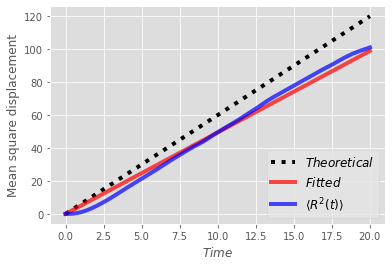

In [7]:
"""for i in range(nums):
    if np.size(Rs[i,:, :]) != np.size(np.unique(Rs[i,:, :], axis=1)):
        print("Particle overlap at " + i)"""

# mean square displacement vs time
msd1 = np.zeros([nums, nump])
for i in range(nums): # loop over time steps
    diff = Rs[i,:,:] - R0[:,:]
    pos2 = np.power(diff, 2)
    summ = np.sum(pos2, axis=1)
    msd1[i,:] = summ
    
msd = np.mean(msd1, axis=1)
#print(msd1)
#print(msd)

dmsd = np.trapz(msd, dx=dt)/ (3*(nums*dt)**2) # integrate using trapezoidal rule

"""fit = np.polyfit(time, msd, 1)
print('Fitted D =',fit[0]/6,'in cm^2 min^-1')
d1 = fit[0]/6

predict = np.poly1d(fit)
theory = predict(time)"""

dmsdfit = 6*dmsd*time

print('D =',kBT/zeta,'(Theoretical)')
print('D =',dmsd,'(Simulation via MSD)')
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_xlabel(r"$Time$",fontsize=12)
ax.set_ylabel(r"Mean square displacement",fontsize=12)
#ax.plot(time,6*kBT/zeta*time,'k',lw=4, ls='dotted', label=r'$6D\,t={6k_BT \,t}/{\zeta}$')
ax.plot(time,6*kBT/zeta*time,'k',lw=4, ls='dotted', label=r'$Theoretical$')
ax.plot(time,dmsdfit,'r',lw=4, alpha=0.7, label=r'$Fitted$')
ax.plot(time, msd,'b',lw=4, alpha=0.7, label=r'$\langle R^2(t)\rangle$')
ax.legend(fontsize=12,loc=4)
plt.savefig('Figures/einstein discrete msd.pdf', bbox_inches='tight')
plt.show()

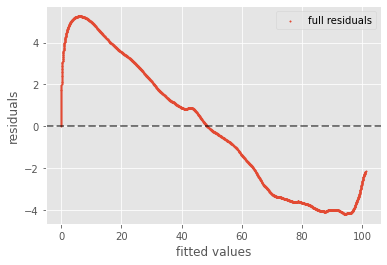

In [8]:
#ratio1 = (theory-fit[1]) - msd

ratio2 = dmsdfit - msd

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(msd, ratio1, s=2, label='polyfit residuals') # plot y/ya vs. t
ax.scatter(msd, ratio2, s=2, label='full residuals') # plot y/ya vs. t
ax.axhline(y=0, color='k', alpha=0.5, lw=2 ,linestyle='--')
ax.set_xlabel(r"fitted values", fontsize=12)
ax.set_ylabel(r"residuals", fontsize=12)
#ax.set_ylim(ymin=0.8, ymax= 1.1)
ax.legend() #display legends
plt.savefig('Figures/einstein discrete residuals.pdf', bbox_inches='tight')
plt.show() #display plots

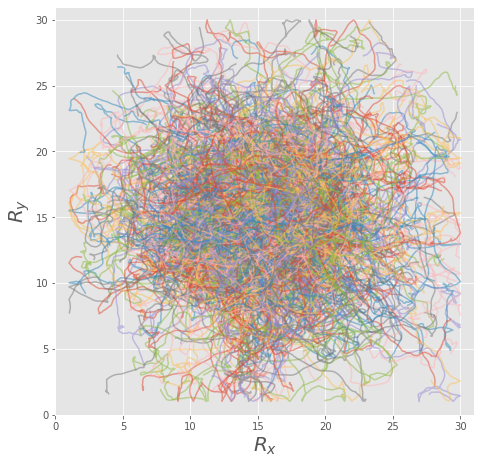

In [9]:
fig, ax = plt.subplots(figsize=(7.5,7.5)) # set fig with its size 7.5 x 7.5 inch
#ax.set_title('{:.1f} ms'.format(nums*dt*1000))
ax.set_xlabel(r"$R_x$", fontsize=20) # set x-label
ax.set_ylabel(r"$R_y$", fontsize=20) # set y-label
ax.set_xlim(0,nx) # set x-range
ax.set_ylim(0,ny) # set y-range
ax.plot(Rs[:,:,0],Rs[:,:,1],alpha=0.5) # plot trajectiries of all particles
plt.savefig('Figures/einstein discrete 2D paths.pdf', bbox_inches='tight')
plt.show() # draw plots

KeyboardInterrupt: 

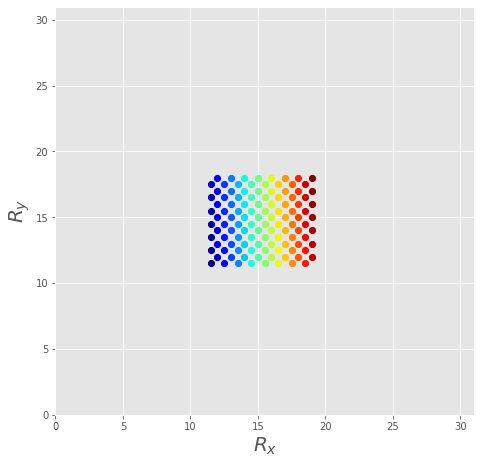

In [10]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,nump)))
    
fig, ax = plt.subplots(figsize=(7.5,7.5)) # set fig with its size 7.5 x 7.5 inch
#ax.set_title('{:.1f} ms'.format(0*dt*1000))
ax.set_xlabel(r"$R_x$", fontsize=20) # set x-label
ax.set_ylabel(r"$R_y$", fontsize=20) # set y-label
ax.set_xlim(0,nx) # set x-range
ax.set_ylim(0,ny) # set y-range
for n in range(nump): # repeat from n=0 to nump-1
    ax.scatter(Rs[0,n,0],Rs[0,n,1],color=next(colors),alpha=0.5) # plot trajectiries of all particles
plt.savefig('Figures/einstein discrete 2D initial.pdf', bbox_inches='tight')
plt.show() # draw plots

colors = iter(jet(np.linspace(0,1,nump)))

fig, ax = plt.subplots(figsize=(7.5,7.5)) # set fig with its size 7.5 x 7.5 inch
#ax.set_title('{:.1f} ms'.format(nums*dt*1000))
ax.set_xlabel(r"$R_x$", fontsize=20) # set x-label
ax.set_ylabel(r"$R_y$", fontsize=20) # set y-label
ax.set_xlim(0,nx) # set x-range
ax.set_ylim(0,ny) # set y-range
for n in range(nump): # repeat from n=0 to nump-1
    ax.scatter(Rs[-1,n,0],Rs[-1,n,1],color=next(colors),alpha=0.5) # plot trajectiries of all particles
plt.savefig('Figures/einstein discrete 2D final.pdf', bbox_inches='tight')
plt.show() # draw plots

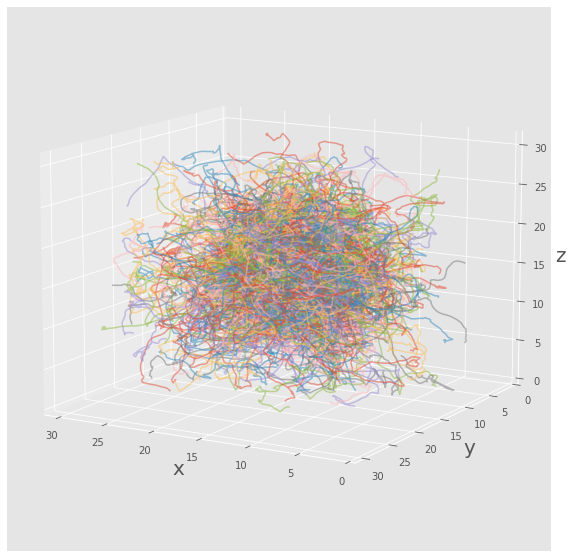

In [10]:
fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
ax.set_xlim(0,nx) # set x-range
ax.set_ylim(0,ny) # set y-range
ax.set_zlim(0,nz) # set z-range
ax.set_xlabel(r"x",fontsize=20) # set x-label
ax.set_ylabel(r"y",fontsize=20) # set y-label
ax.set_zlabel(r"z",fontsize=20) # set z-label
ax.view_init(elev=12,azim=120) # set view point
for n in range(nump): # repeat from n=0 to nump-1
    ax.plot(Rs[:,n,0],Rs[:,n,1],Rs[:,n,2],alpha=0.5) # plot trajectiries of all particle
plt.savefig('Figures/einstein discrete 3D paths.pdf', bbox_inches='tight')
plt.savefig('Figures/einstein discrete 3D paths.png', bbox_inches='tight')
plt.show() # draw plots

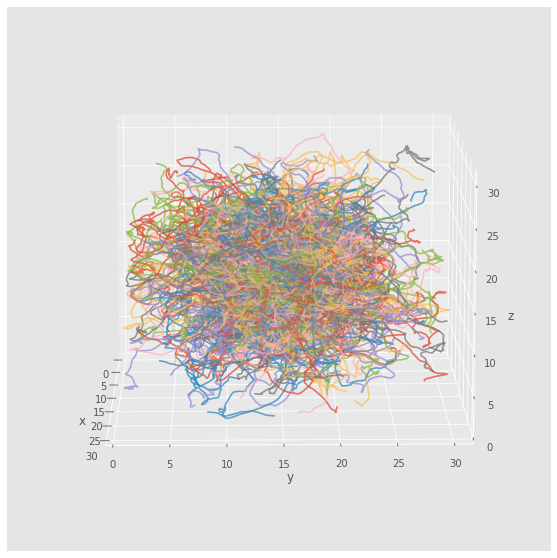

In [11]:
#jet= plt.get_cmap('jet')
#colors = iter(jet(np.linspace(0,1,num)))

# Create a figure and a 3D Axes
fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
ax.set_xlim(0,nx) # set x-range
ax.set_ylim(0,ny) # set y-range
ax.set_zlim(0,nz) # set z-range
ax.set_xlabel(r"x",fontsize=12) # set x-label
ax.set_ylabel(r"y",fontsize=12) # set y-label
ax.set_zlabel(r"z",fontsize=12) # set z-label

# Create an init function and the animate functions.
# Both are explained in the tutorial. Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function. (return value is explained
# in the tutorial.
def init():
    for n in range(nump): # repeat from n=0 to nump-1
        ax.plot(Rs[:,n,0],Rs[:,n,1],Rs[:,n,2],alpha=0.5) # plot trajectiries of all particle
    return fig,

def animate(i):
    ax.view_init(elev=12., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save(r'Figures/einstein discrete 3D rotation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

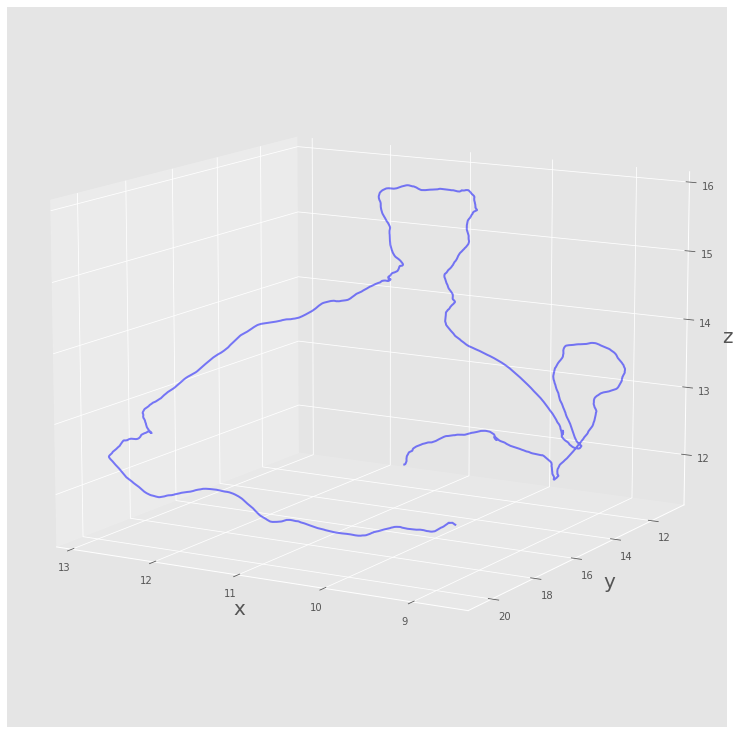

In [35]:
# ANIMATION FUNCTION
def func(num, dataSet, line):
    # NOTE: there is no .set_data() for 3 dim data...
    line.set_data(dataSet[0:2, :num])    
    line.set_3d_properties(dataSet[2, :num])    
    return line

# THE DATA POINTS
dataSet = np.array([Rs[:,0,0], Rs[:,0,1], Rs[:,0,2]])
numDataPoints = len(Rs[:,0,0])
 
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
 
# NOTE: Can't pass empty arrays into 3d version of plot()
line = plt.plot(dataSet[0], dataSet[1], dataSet[2], lw=2, alpha = 0.5, c='b')[0] # For line plot
 
# AXES PROPERTIES]
# ax.set_xlim3d([limit0, limit1])
#ax.set_xlim3d(0,nx) # set x-range
#ax.set_ylim3d(0,ny) # set y-range
#ax.set_zlim3d(0,nz) # set z-range
ax.set_xlabel(r"x",fontsize=20) # set x-label
ax.set_ylabel(r"y",fontsize=20) # set y-label
ax.set_zlabel(r"z",fontsize=20) # set z-label
ax.view_init(elev=12,azim=120) # set view point
 
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, func, frames=numDataPoints, fargs=(dataSet,line), interval=5, blit=False)
line_ani.save(r'Figures/einstein discrete 3D single.mp4')
 
 
plt.show() # draw plots

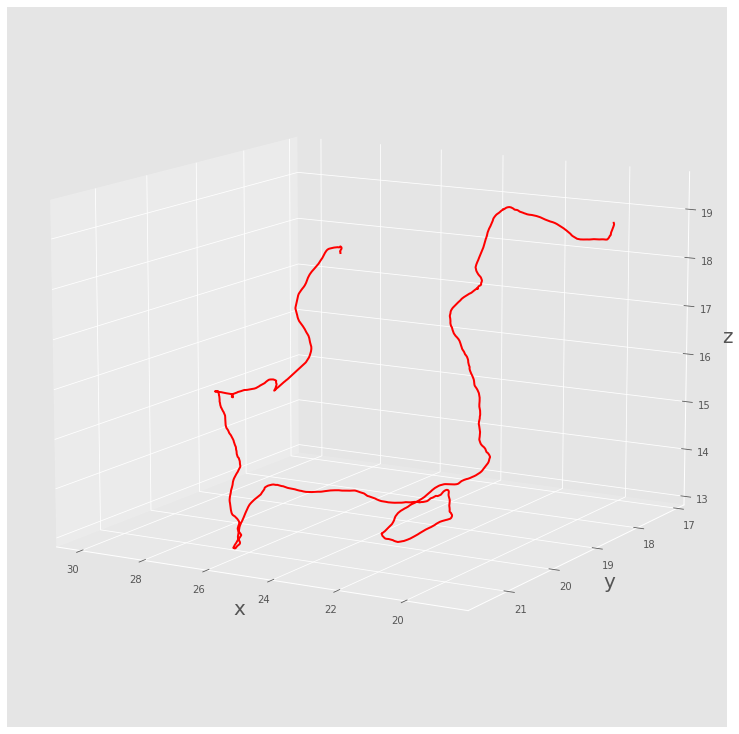

In [34]:
# THE DATA POINTS
dataSet = np.array([Rs[:,-1,0], Rs[:,-1,1], Rs[:,-1,2]])
numDataPoints = len(Rs[:,0,0])
 
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
 
# NOTE: Can't pass empty arrays into 3d version of plot()
line = plt.plot(dataSet[0], dataSet[1], dataSet[2], lw=2, alpha = 0.5, c='r')[0] # For line plot
 
# AXES PROPERTIES]
# ax.set_xlim3d([limit0, limit1])
#ax.set_xlim3d(0,nx) # set x-range
#ax.set_ylim3d(0,ny) # set y-range
#ax.set_zlim3d(0,nz) # set z-range
ax.set_xlabel(r"x",fontsize=20) # set x-label
ax.set_ylabel(r"y",fontsize=20) # set y-label
ax.set_zlabel(r"z",fontsize=20) # set z-label
ax.view_init(elev=12,azim=120) # set view point
 
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, func, frames=numDataPoints, fargs=(dataSet,line), interval=5, blit=False)
line_ani.save(r'Figures/einstein discrete 3D single 2.mp4')
 
plt.show() # draw plots

(1792000,)
0
0.009903929010391362
-0.04951964505195681
0.04951964505195681
50
[0.00983042]


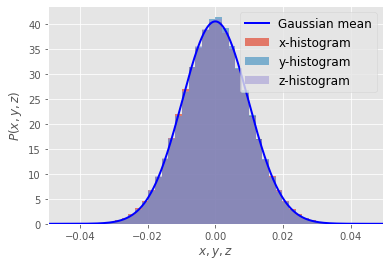

In [41]:
x_diff = np.diff(Rs[:,:,0], axis=0)
x_diff = x_diff.flatten()

y_diff = np.diff(Rs[:,:,1], axis=0)
y_diff = y_diff.flatten()

z_diff = np.diff(Rs[:,:,2], axis=0)
z_diff = z_diff.flatten()

print(np.shape(x_diff))
#print(np.amax(x_diff))
#print(np.amin(x_diff))

#print(np.amax(y_diff))
#print(np.amin(y_diff))

#print(np.amax(z_diff))
#print(np.amin(z_diff))

stepsize_array = np.concatenate((x_diff,y_diff,z_diff), axis=None)
(ave, std) = norm.fit(stepsize_array,floc=0)

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 50
print(ave)
print(std)
print(nmin)
print(nmax)
print(nbin)

fig = plt.figure()
ax = fig.add_subplot(111)

height1, _, _ = ax.hist(x_diff,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.7,label=r'x-histogram') # plot normalized histogram of L
height2, _, _ = ax.hist(y_diff,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.6,label=r'y-histogram') # plot normalized histogram of L
height3, _, _ = ax.hist(z_diff,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.5,label=r'z-histogram') # plot normalized histogram of L
height4, bins, _ = ax.hist(stepsize_array,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0) # plot to get parameters, dont want visible

bin_centers = bins[:-1] + np.diff(bins) / 2

popt, _ = curve_fit(gaussian, bin_centers, np.mean([height1,height2,height3], axis=0), p0=[2e-3])
print(popt)

best_fit_line = norm.pdf(bins, ave, std)

xyz_fit = np.linspace(bins[0], bins[-1], 10000)

ax.plot(xyz_fit, gaussian(xyz_fit, *popt),lw=2,color='b', label=r'Gaussian mean')
#ax.plot(bins,best_fit_line,lw=2,color='k',label=r'Norm fit') # plot y vs. x with blue line
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$x,y,z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x,y,z)$',fontsize=12) # set y-label
ax.legend(fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/einstein discrete xyz step size.pdf', bbox_inches='tight')
plt.show() # display plots

0.0 ms


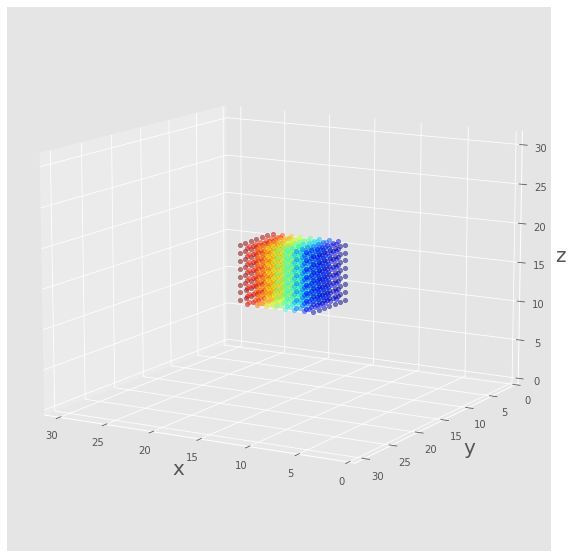

100.0 ms


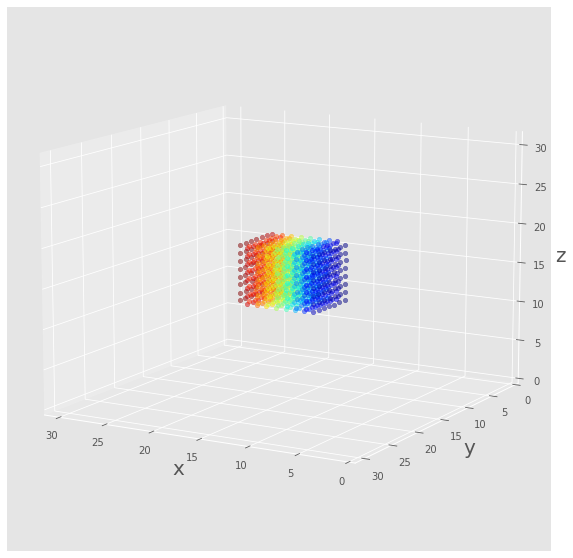

500.0 ms


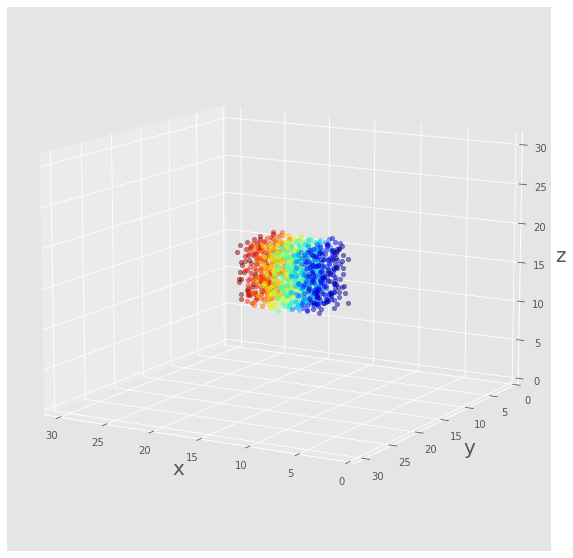

1000.0 ms


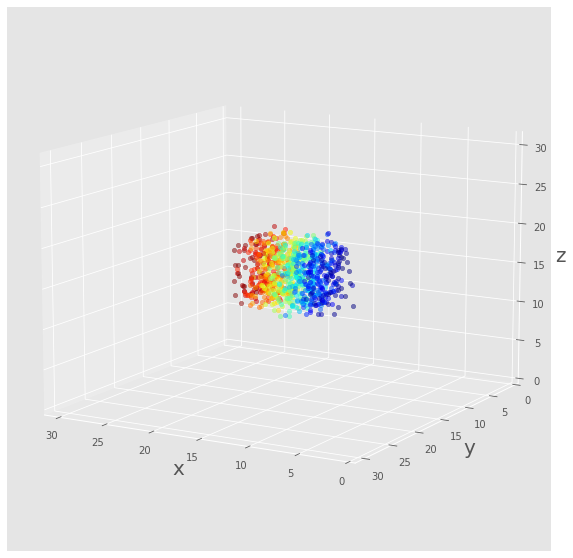

2500.0 ms


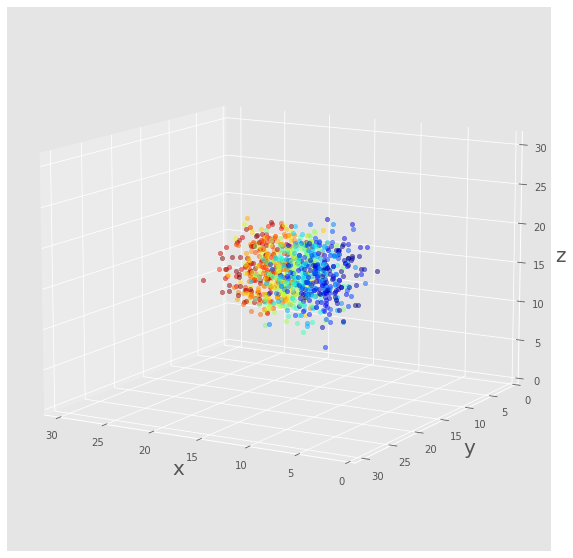

5000.0 ms


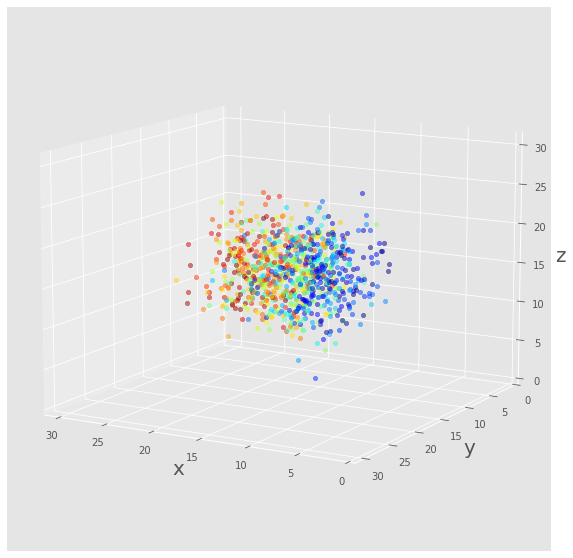

10000.0 ms


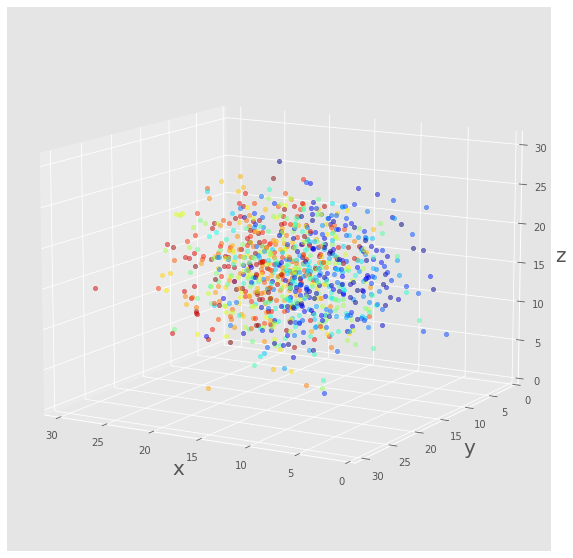

20000.0 ms


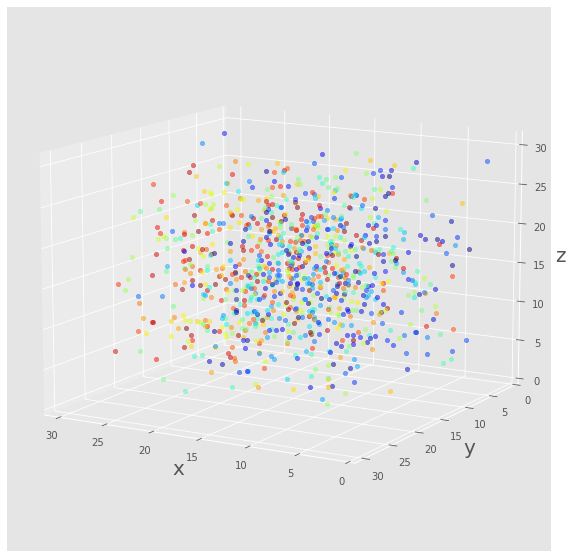

In [11]:
timesteps = [0, 10, 50, 100, 250, 500, 1000, nums-1]

for ts in timesteps:
    print('{:.1f} ms'.format(ts*dt*1000))
    colors = iter(jet(np.linspace(0,1,nump)))
    fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
    ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
    #ax.set_title('{:.1f} ms'.format(ts*dt*1000))
    ax.set_xlim(0,nx) # set x-range
    ax.set_ylim(0,ny) # set y-range
    ax.set_zlim(0,nz) # set z-range
    ax.set_xlabel(r"x",fontsize=20) # set x-label
    ax.set_ylabel(r"y",fontsize=20) # set y-label
    ax.set_zlabel(r"z",fontsize=20) # set z-label
    ax.view_init(elev=12,azim=120) # set view point
    for n in range(nump): # repeat from n=0 to nump-1
        #if ts == 0:
        ax.scatter(Rs[ts,n,0],Rs[ts,n,1],Rs[ts,n,2],color=next(colors),alpha=0.5) # plot trajectiries of all particle
        #else:
            #ax.plot(Rs[:ts,n,0],Rs[:ts,n,1],Rs[:ts,n,2],color=next(colors),alpha=0.5) # plot trajectiries of all particle
    #ax.plot(Rs[:,0,0],Rs[:,0,1],Rs[:,0,2],alpha=0.5) 
    plt.savefig('Figures/einstein discrete 3D diffusion %s steps.pdf' % ts, bbox_inches='tight')
    plt.savefig('Figures/einstein discrete 3D diffusion %s steps.png' % ts, bbox_inches='tight')
    plt.show() # draw plots

0
6.324555320336759


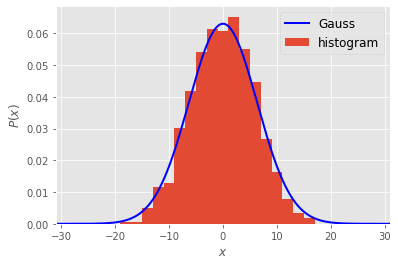

In [12]:
ave = 0 # Average position i.e. starting position
std = np.sqrt(2*kBT/zeta*time[nums-1]) # Standard deviation i.e. sqrt(2Dt)

nmin=int(ave-std*5)
nmax=int(ave+std*5)
nbin=int((nmax-nmin)/2)

fig = plt.figure()
ax = fig.add_subplot(111)

print(ave)
print(std)

ax.hist(Rs[nums-1,:,0]-Rs[0,:,0],range=[nmin,nmax],bins=nbin,density=True, stacked=True) # plot normalized histogram of L

x1 = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment
y = np.exp(-(x1-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

ax.plot(x1,y,lw=2,color='b') # plot y vs. x with blue line
#ax.set_title(r'x-axis particle distribution')
ax.set_xlabel(r'$x$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x)$',fontsize=12) # set y-label
ax.legend([r'Gauss',r'histogram'], fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/einstein discrete x distr.pdf', bbox_inches='tight')
plt.show() # display plots

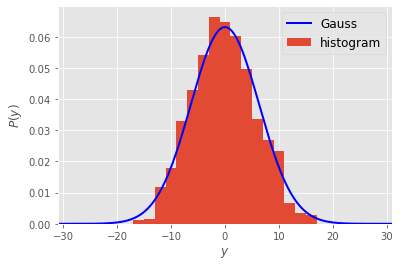

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(Rs[nums-1,:,1]-Rs[0,:,1],range=[nmin,nmax],bins=nbin,density=True, stacked=True) # plot normalized histogram of L

x1 = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment 
y = np.exp(-(x1-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

ax.plot(x1,y,lw=2,color='b') # plot y vs. x with blue line
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$y$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(y)$',fontsize=12) # set y-label
ax.legend([r'Gauss',r'histogram'], fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/einstein discrete y distr.pdf', bbox_inches='tight')
plt.show() # display plots

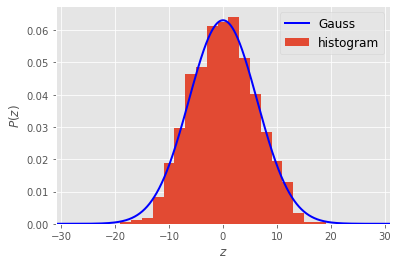

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(Rs[nums-1,:,2]-Rs[0,:,2],range=[nmin,nmax],bins=nbin,density=True, stacked=True) # plot normalized histogram of L

x1 = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment 
y = np.exp(-(x1-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

ax.plot(x1,y,lw=2,color='b') # plot y vs. x with blue line
#ax.set_title(r'z-axis particle distribution')
ax.set_xlabel(r'$z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(z)$',fontsize=12) # set y-label
ax.legend([r'Gauss',r'histogram'], fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/einstein discrete z distr.pdf', bbox_inches='tight')
plt.show() # display plots

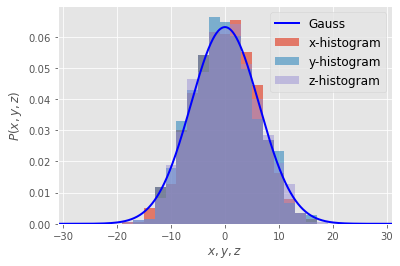

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(Rs[nums-1,:,0]-Rs[0,:,0],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.7,label=r'x-histogram') # plot normalized histogram of L
ax.hist(Rs[nums-1,:,1]-Rs[0,:,1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.6,label=r'y-histogram') # plot normalized histogram of L
ax.hist(Rs[nums-1,:,2]-Rs[0,:,2],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.5,label=r'z-histogram') # plot normalized histogram of L

x1 = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment y = np.exp(-(x-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical plt.plot(x,y,lw=2,color='b') # plot y vs. x with blue line
y = np.exp(-(x1-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

ax.plot(x1,y,lw=2,color='b',label=r'Gauss') # plot y vs. x with blue line
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$x,y,z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x,y,z)$',fontsize=12) # set y-label
ax.legend(fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/einstein discrete xyz distr.pdf', bbox_inches='tight')
plt.show() # display plots